In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
from scipy.stats import norm

//anaconda/envs/python3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


#  Homework 2

## APMTH 207: Stochastic Methods for Data Analysis, Inference and Optimization

**Due Date: ** Thursday, Febrary 9th, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Monte Carlo Integration

Let $X$ be a random variable with distribution described by the following pdf:
$$
f_X(x) = \begin{cases}
\frac{1}{12}(x-1), &1\leq x\leq 3\\
-\frac{1}{12}(x-5), &3< x\leq 5\\
\frac{1}{6}(x-5), &5< x\leq 7\\
-\frac{1}{6}(x-9), &7< x\leq 9\\
0, &otherwise
\end{cases}
$$
Let $h$ be the following function of $X$:
$$
h(X) = \frac{1}{3\sqrt{2}\pi}\mathrm{exp}\left\{ -\frac{1}{18}\left( X - 5\right)^2\right\}
$$

Compute $\mathbb{E}[h(X)]$ via Monte Carlo simulation using the following sampling methods:
- inverse transform sampling
- rejection sampling with both uniform proposal distribution and normal proposal distribution (steroids) (with appropriately chosen parameters)
- importance sampling with both uniform proposal distribution and normal proposal distribution (with appropriately chosen parameters)

### Approach

Applying LOTUS,  the expectation can be written as:

$$
\mathbb{E}[h(X)] = \int_{-\infty}^{+\infty} h(x)f(x) dx
$$

To compute this expectation samples can be drawn from $f_X(x)$ in each of the 4 regions, and by applying the law of large numbers the expectation can be approximated by an average given by:

$$E_{f}[\hat{h}]=\frac{1}{N}\sum_{x_i ∼ f(x)}h(x_i)$$  

The $x_i$s can be drawn from $f_X(x)$ in each of the regions using the different sampling methods. 

## Define p(x), CDF(x) and InvCDF(x)

Each section of f(x) can be integrated piecewise and the full CDF constructed by adding appropriate constants to each section of the function. 

In [72]:
# probability distribution we're trying to calculate
p = lambda x: (1/12)*(x-1)*(1<=x)*(x<=3) + (-1/12)*(x-5)*(3<x)*(x<=5) + (1/6)*(x-5)*(5<x)*(x<=7) + (-1/6)*(x-9)*(7<x)*(x<=9)

# CDF of p
CDF = lambda x: ((1/12)*((x**2)/2 - x +0.5)*(1<=x)*(x<=3) 
                 + ((-1/12)*((x**2)/2-5*x + 10.5) + (1/6))*(3<x)*(x<=5)  
                 + ((1/6)*((x**2)/2-5*x + 12.5) + (1/3))*(5<x)*(x<=7) 
                 + ((-1/6)*((x**2)/2-9*x + 38.5) + (2/3))*(7<x)*(x<=9)
                )

CDF1 = lambda x: ((1/12)*((x**2)/2 - x +0.5)*(1<=x)*(x<=3) 
                 + ((-1/12)*((x**2)/2-5*x + 8.5))*(3<x)*(x<=5)  
                 + ((1/6)*((x**2)/2-5*x + 14.5))*(5<x)*(x<=7) 
                 + ((-1/6)*((x**2)/2-9*x + 34.5))*(7<x)*(x<=9)
                )

Hx = lambda x: (1/(3*np.sqrt(2)*np.pi))*np.exp(-(1/18)*((x-5)**2)) 

In [73]:
## calculate the limits for the invCDF

fx1 = lambda x: (1/12)*((x**2)/2 - x +0.5)
print (fx1(1), ',', fx1(3))

fx2 = lambda x: (-1/12)*((x**2)/2-5*x + 8.5)
print (fx2(3), ',', fx2(5))

fx3 = lambda x: (1/6)*((x**2)/2-5*x + 14.5)
print (fx3(5), ',', fx3(7))

fx4 = lambda x: (-1/6)*((x**2)/2-9*x + 34.5)
print (fx4(7), ',', fx4(9))

0.0 , 0.16666666666666666
0.16666666666666666 , 0.3333333333333333
0.3333333333333333 , 0.6666666666666666
0.6666666666666666 , 1.0


In [74]:
def invCDF(u):
    if ((0<=u) and (u<=(1/6))):
        return (1+np.sqrt(24*u))
    elif (((1/6)<=u) and (u<(1/3))):
        return (5-np.sqrt(8-24*u))
    elif (((1/3)<=u) and (u<(2/3))):
        return (5+ np.sqrt(12*u -4))
    elif (((2/3)<=u) and (u<1)):
        return (9 - np.sqrt(12 - 12*u))
    elif (u>=1):
        return 9
    else:
        return 0
    
invCDF = np.vectorize(invCDF)

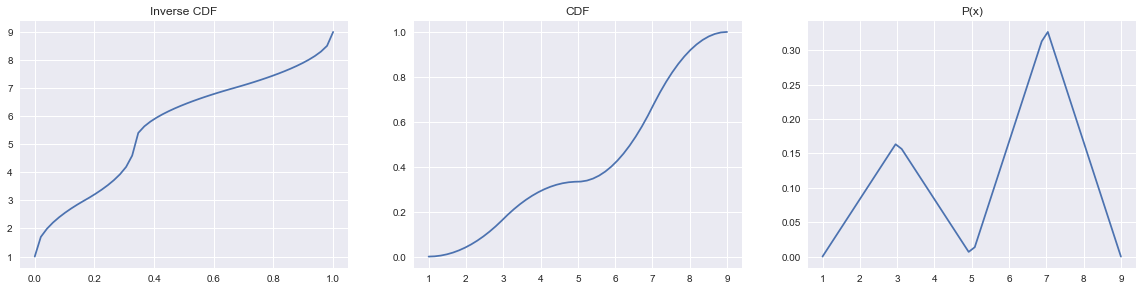

In [75]:
# plot p(X), cdf(x) and invcdf(x)
x = np.linspace(1,9)
u = np.linspace(0,1)
plt.figure(figsize=(20,10))
plt.subplot(231)
plt.plot(u, invCDF(u))
plt.title('Inverse CDF')
plt.subplot(232)
plt.plot(x, CDF1(x))
plt.title('CDF')
plt.subplot(233)
plt.plot(x, p(x))
plt.title('P(x)')

# Sampling Methods

For each method, 1000 iterations (N) of the sampling process was carried out, each time drawing 10000 samples (M). 

## Inverse Transform Sampling

In [76]:
Eh_inverse = np.zeros((1000,1))

for i in range(1000):
    # domain limits
    xmin = 1 # the lower limit of our domain
    xmax = 9 # the upper limit of our domain

    # range limits
    rmin = CDF(xmin)
    rmax = CDF(xmax)

    N = 10000 # the total of samples we wish to generate

    # generate uniform samples in our range then invert the CDF
    # to get samples of our target distribution
    R = np.random.uniform(rmin, rmax, N)
    X = invCDF(R)
    
    Eh_inverse[i] = np.mean(Hx(X))

print("Variance of our estimates: ", np.var(Eh_inverse))

Variance of our estimates:  1.03864453742e-08


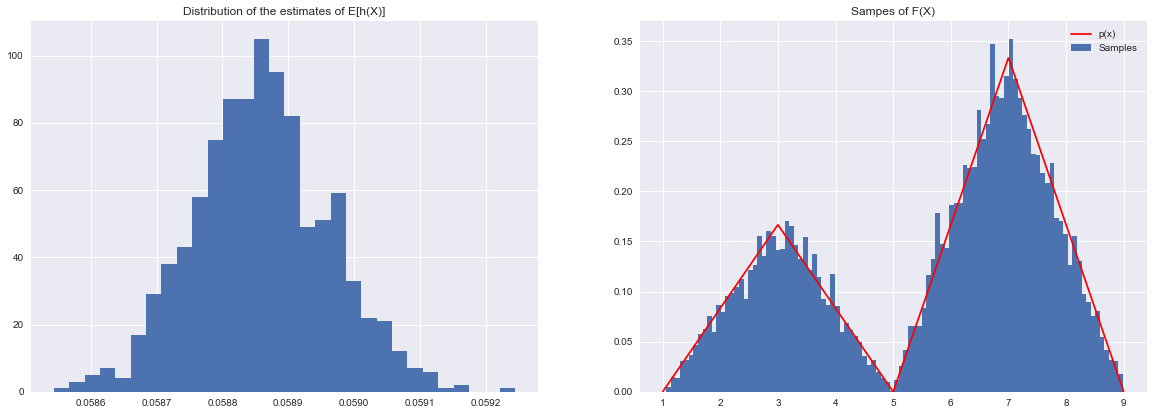

In [77]:
# plot the histogram of estimates 
plt.figure(figsize=(20,15))
plt.subplot(221)
plt.hist(Eh_inverse,bins=30, label=u'Samples');
plt.title('Distribution of the estimates of E[h(X)]')

# get the histogram info
hinfo = np.histogram(X,100)

plt.subplot(222)
# plot the histogram
plt.hist(X,bins=100, label=u'Samples', normed=True);
xvals=np.linspace(xmin, xmax, 1000)
plt.plot(xvals, p(xvals), 'r', label=u'p(x)')
plt.title('Sampes of F(X)')

# turn on the legend
plt.legend()

### Rejection Sampling: uniform proposal distribution

In [78]:
Eh_rej_uniform = np.zeros((1000, 1))

# domain limits
xmin = 1 # the lower limit of our domain
xmax = 9 # the upper limit of our domain


for i in range(1000):
    # range limit (supremum) for y
    ymax = 1

    N = 10000 # the total of samples we wish to generate
    accepted = 0 # the number of accepted samples
    samples = np.zeros(N)
    count = 0 # the total count of proposals

    # generation loop
    while (accepted < N):

        # pick a uniform number on [xmin, xmax) (e.g. 0...10)
        x = np.random.uniform(xmin, xmax)

        # pick a uniform number on [0, ymax)
        y = np.random.uniform(0,ymax)

        # Do the accept/reject comparison
        if y < p(x):
            samples[accepted] = x
            accepted += 1

        count +=1
    Eh_rej_uniform[i] = np.mean(Hx(samples))

Variance of our estimates:  1.02586540644e-08


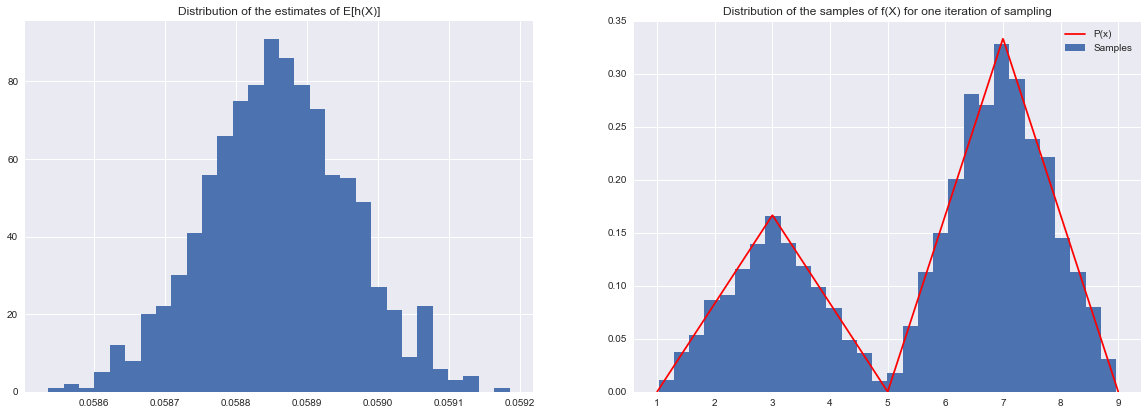

In [79]:
# print("Count",count, "Accepted", accepted)

plt.figure(figsize=(20,15))

plt.subplot(221)
# Plot the histogram of the estimates
plt.hist(Eh_rej_uniform, bins=30)
plt.title('Distribution of the estimates of E[h(X)]')

# Plot a histogram of the samples 

plt.subplot(222)
hinfo = np.histogram(samples,30)
plt.hist(samples,bins=30, label=u'Samples', normed=True);
xvals=np.linspace(xmin, xmax, 1000)
plt.plot(xvals, P(xvals), 'r', label=u'P(x)')
plt.title('Distribution of the samples of f(X) for one iteration of sampling')
plt.legend()

print("Variance of our estimates: ", np.var(Eh_rej_uniform))

## Rejection sampling: normal proposal distribution (steroids)

###  Determine an appropriate normal sampling distribution

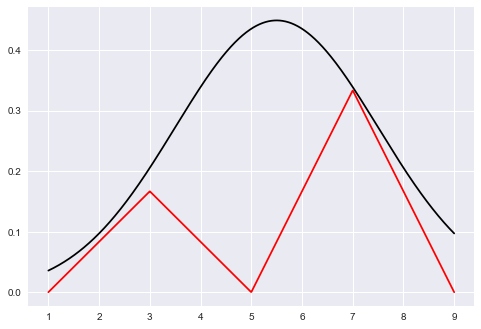

In [80]:
## normal proposal distribution 
mu = 5.5
sigma = 2
M = 2.25
g = lambda x: M*(1/np.sqrt(2*math.pi*sigma**2))*np.exp(-((x-mu)**2)/(2*sigma**2))

# plot our (normalized) function
xvals=np.linspace(xmin, xmax, 1000)
plt.plot(xvals, p(xvals), 'r', label=u'p(x)')
plt.plot(xvals, g(xvals), 'k', label=u'g(x)')

In [81]:
Eh_rej_normal = np.zeros((1000,1))

for i in range(1000):
    N = 10000 # the total of samples we wish to generate
    accepted = 0 # the number of accepted samples
    samples = np.zeros(N)

    # generation loop
    while (accepted < N):

        # sample from the normal distribution
        xproposal = np.random.normal(mu,sigma)

        # pick a uniform number on [0, 1)
        y = np.random.uniform(0,1)

        # Do the accept/reject comparison
        if y < p(xproposal)/(g(xproposal)):
            samples[accepted] = xproposal
            accepted += 1

    Eh_rej_normal[i] = np.mean(Hx(samples))

Standard deviation of our estimates:  9.73230267846e-09


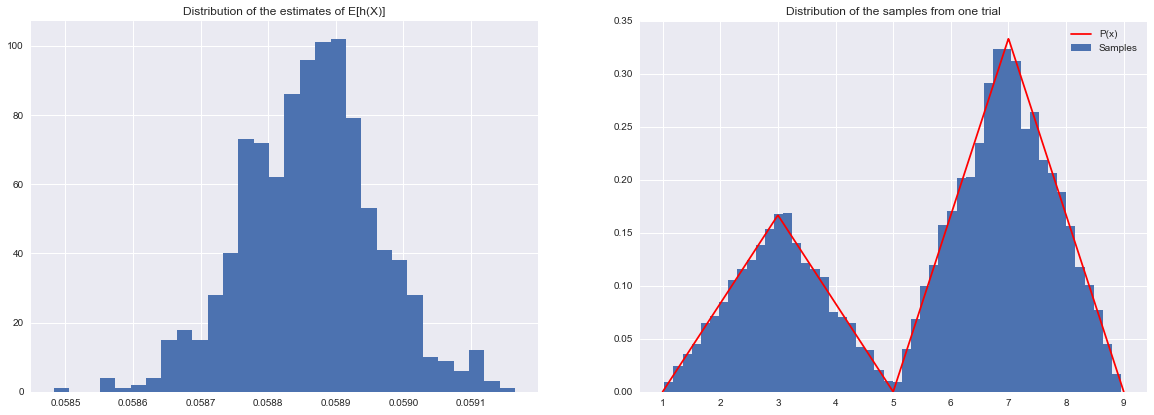

In [82]:
plt.figure(figsize=(20,15))

plt.subplot(221)
# plot histogram of estimates:
plt.hist(Eh_rej_normal, bins=30)
plt.title('Distribution of the estimates of E[h(X)]')

plt.subplot(222)
# plot histogram of the samples
hinfo = np.histogram(samples,50)
plt.hist(samples,bins=50, label=u'Samples', normed=True);
plt.plot(xvals, P(xvals), 'r', label=u'P(x)')
plt.title('Distribution of the samples from one trial')
plt.legend()

print("Standard deviation of our estimates: ", np.var(Eh_rej_normal))

## Importance sampling: uniform proposal distribution

In [83]:
Eh_imp_uniform = np.zeros((1000, 1))

# domain limits
xmin = 1 # the lower limit of our domain
xmax = 9 # the upper limit of our domain

for i in range(1000):
    N = 10000 # the total of samples we wish to generate
    accepted = 0 # the number of accepted samples
    samples = np.zeros(N)

    # generation loop
    for j in range(N):
        samples[j] = np.random.uniform(xmin, xmax)

    Eh_imp_uniform[i] = np.mean((p(samples)*(xmax-xmin))*Hx(samples));
    
print("Standard deviation of our estimates: ", np.var(Eh_imp_uniform))

Standard deviation of our estimates:  1.96238314507e-07


## Importance sampling: normal proposal distribution (with appropriately chosen parameters)

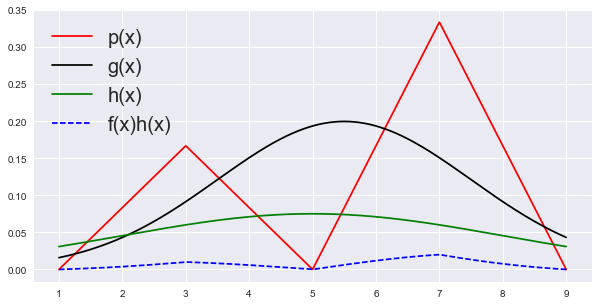

In [84]:
mu = 5.5;
sig = 2;

xmin = 1
xmax = 9

# sampling distribution
g = lambda x: (1/np.sqrt(2*np.pi*sig**2))*np.exp(-(x-mu)**2/(2.0*sig**2))

# plot our (normalized) function
plt.figure(figsize=(10,5))
xvals=np.linspace(xmin, xmax, 1000)
plt.plot(xvals, f(xvals), 'r', label=u'p(x)')
plt.plot(xvals, g(xvals), 'k', label=u'g(x)')
plt.plot(xvals, Hx(xvals), 'g', label=u'h(x)')
plt.plot(xvals, f(xvals)*Hx(xvals), 'b--', label=u'f(x)h(x)')
plt.legend(fontsize=20)

In [85]:
normfun = lambda x:  norm.cdf(x-mu, scale=sig)

Eh_imp_normal = np.zeros(1000)

N = 10000

# normalization for gaussian from 1-9
normal = normfun(9)-normfun(1) 

for i in range(1000):
    accepted = 0 # the number of accepted samples
    samples = np.zeros(N)
    # generation loop
    while (accepted < N):
        # sample from sampling distribution 
        xis = np.random.normal(mu, sig)
        if (xis <= xmax) and (xis >= xmin):
            samples[accepted] = xis
            accepted += 1     
    Eh_imp_normal[i] = np.mean((p(samples)/g(samples))*Hx(samples))*normal;

print("Standard deviation of our estimates: ", np.var(Eh_imp_normal))

Standard deviation of our estimates:  1.41350454453e-07


## Problem 2: Variance Reduction

### Part A

Compute the variance of each estimate of $\mathbb{E}[h(X)]$ obtained in Problem 1. Based on the discussion on sampling methods in lecture, which sampling methods, proposal distributions is expected, in principle, to resulted in lower variances? How well do your results align with these expectations?

## Comparison of sampling methods

(array([   0.,   20.,   40.,   60.,   80.,  100.,  120.]),
 <a list of 7 Text yticklabel objects>)

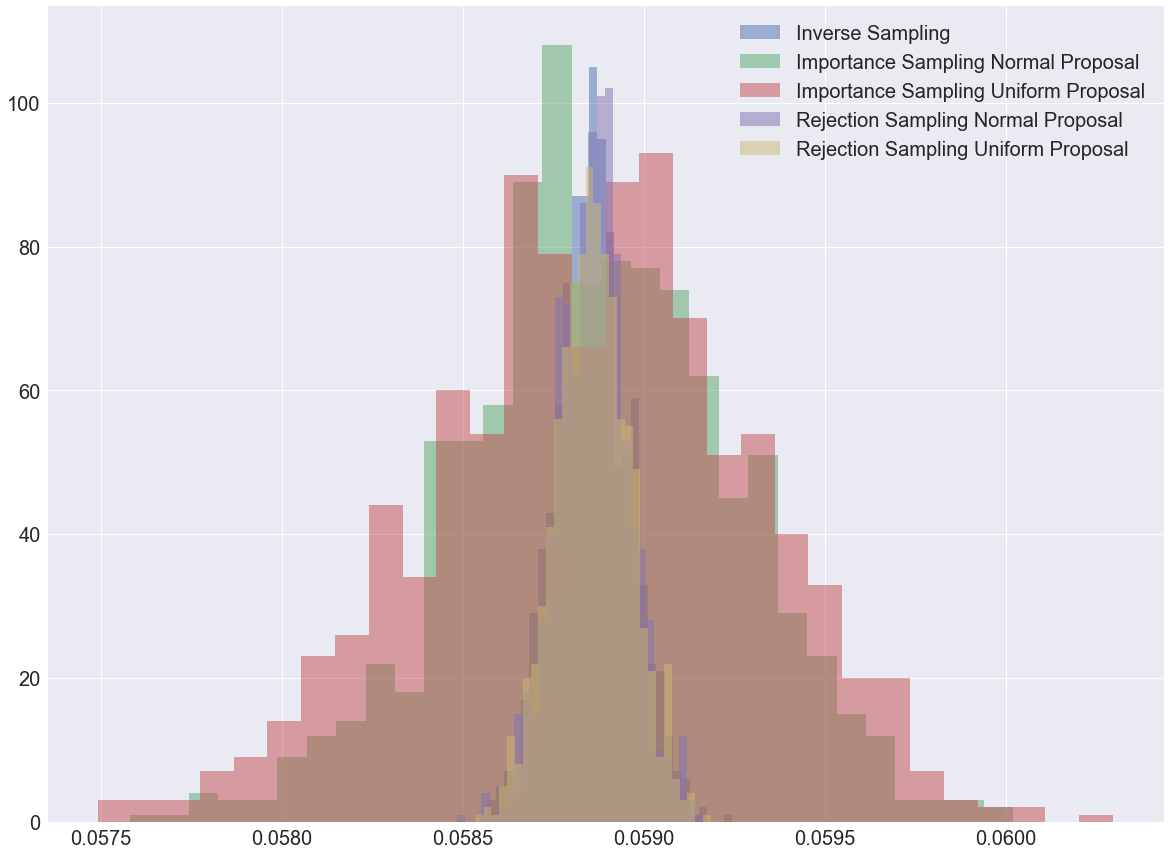

In [86]:
plt.figure(figsize=(20,15))
plt.hist(Eh_inverse,bins=30, alpha = 0.5, label='Inverse Sampling');
plt.hist(Eh_imp_normal,bins=30,alpha = 0.5, label='Importance Sampling Normal Proposal');
plt.hist(Eh_imp_uniform,bins=30, alpha = 0.5,label='Importance Sampling Uniform Proposal');
plt.hist(Eh_rej_normal, bins=30, alpha = 0.5, label='Rejection Sampling Normal Proposal');
plt.hist(Eh_rej_uniform,bins=30, alpha = 0.5,label='Rejection Sampling Uniform Proposal');
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [87]:
print('VARIANCES')

print("Inverse Sampling: ", np.var(Eh_inverse))
print("Importance Sampling Normal Proposal: ", np.var(Eh_imp_normal))
print("Importance Sampling Uniform Proposal: ", np.var(Eh_imp_uniform))
print("Rejection Sampling Normal Proposal: ", np.var(Eh_rej_normal))
print("Rejection Sampling Uniform Proposal: ", np.var(Eh_rej_uniform))

VARIANCES
Inverse Sampling:  1.03864453742e-08
Importance Sampling Normal Proposal:  1.41350454453e-07
Importance Sampling Uniform Proposal:  1.96238314507e-07
Rejection Sampling Normal Proposal:  9.73230267846e-09
Rejection Sampling Uniform Proposal:  1.02586540644e-08


In principle, importance sampling should result in lower variance compared to inverse sampling and rejection sampling, however this is dependent on the proposal distribution. If the proposal distribution $g(x)$ is selected such that the term $f(x)/g(x)$ has lower variability than $f(x)$, then importance sampling will result in a better estimate of $E[h(x)]$. However in this problem, rejection sampling with normal proposal distribution resulted in the lowest variance in the estimates. 

### Part B (Stratified Sampling)

Often, a complex integral can be computed with more ease if one can break up the domain of the integral into pieces and if on each piece of the domain the integral is simplified. 

- Find a natural way to divide the domain of $X$ and express $\mathbb{E}[h(X)]$ as an ***correctly*** weighted sum of integrals over the pieces of the domain of $X$. (This constitutes the essentials of Stratified Sampling)

- Estimate each integral in the summand using rejection sampling using a normal proposal distribution (with sensibly chosen parameters). From these, estimate $\mathbb{E}[h(X)]$.

- Compute the variance of your estimate of $\mathbb{E}[h(X)]$. Compare with the variance of your previous estimate of $\mathbb{E}[h(X)]$ (in Part A, using rejection sampling, a normal proposal distribution over the entire domain of $X$).

Read more about Stratified Sampling:

1. [Variance Reduction Techniques Slides](http://www.sta.nus.edu.sg/~zhangjt/teaching/ST4231/lectures/chapter4.pdf)

2. [Monte Carlo Methods](http://www.public.iastate.edu/~mervyn/stat580/Notes/s09mc.pdf)

3. [Variance Reduction Techniques Chapter](http://sas.uwaterloo.ca/~dlmcleis/s906/chapt4.pdf)

The pdf of f(x) can be split into two regions, section 1 spanning the domain $ 1 \le x \le 5$ and section 2 spanning the domain $ 5 \le x \le 9$ . For each section a separate proposal distribution $g_1(x)$ and $g_2(x)$ can be used to sample $x$. 

$$ E[H(x)] = f(E[h(x_1)], E[h(x_2)]) $$
$$ E[H(x)] = \int_1^5 f(x)h(x) dx + \int_5^9 f(x)h(x) dx $$

In order to express the sum of integrals as a sum of expectations, $f(x)$ needs to be normaliased in each of the strata - a normalised pdf is required to calculate an expectation value. 

Normalising $f(x)$ in each stratum involves diviing $f(x)$ by the area under the pdf in that stratum. The expectation therefore becomes a weighting sum of the expectations in each of the two strata. 

$$ E[H(x)] = w_1\int_1^5 \frac{f(x)}{w_1}h(x) dx + w_2\int_5^9 \frac{f(x)}{w_2}h(x) dx $$

where:

$$ E[H(x_1)] = \int_1^5 \frac{f(x)}{w_1}h(x) dx $$

$$ E[H(x_2)] = \int_5^9 \frac{f(x)}{w_2}h(x) dx $$

Therefore the final expectation can be written as:

$$ E[H(x)] = w_1*E[h(x_1)] + w_2*E[h(x_2)] $$

(array([-0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
         0.4 ,  0.45]), <a list of 11 Text yticklabel objects>)

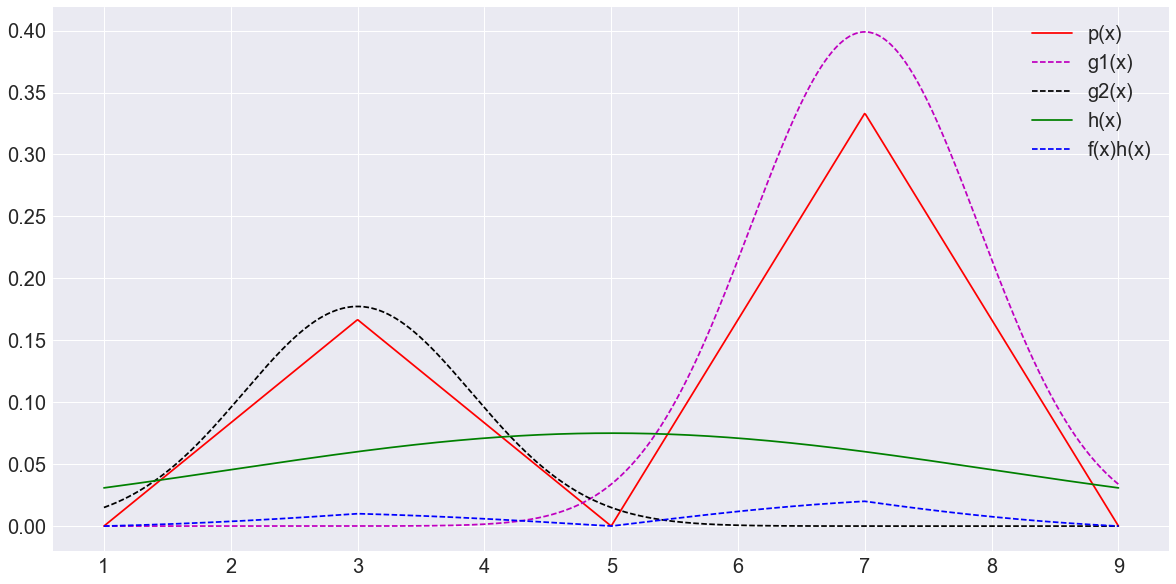

In [88]:
mu1 = 7;
sig1 = 0.9;
M1 = 0.9;

xmin = 1
xmax = 9

# sampling distribution
g1 = lambda x: (1/np.sqrt(2*np.pi*sig1**2))*np.exp(-(x-mu1)**2/(2.0*sig1**2))*M1

mu2 = 3;
sig2 = 0.9;
M2 = 0.4

# sampling distribution
g2 = lambda x: (1/np.sqrt(2*np.pi*sig2**2))*np.exp(-(x-mu2)**2/(2.0*sig2**2))*M2

# plot our (normalized) function
plt.figure(figsize=(20,10))
xvals=np.linspace(xmin, xmax, 1000)
plt.plot(xvals, p(xvals), 'r', label=u'p(x)')
plt.plot(xvals, g1(xvals), 'm--', label=u'g1(x)')
plt.plot(xvals, g2(xvals), 'k--', label=u'g2(x)')
plt.plot(xvals, Hx(xvals), 'g', label=u'h(x)')
plt.plot(xvals, f(xvals)*Hx(xvals), 'b--', label=u'f(x)h(x)')
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [89]:
import time
N = 5000 # the total of samples we wish to generate

w1 = CDF(5)
w2 = CDF(9) - CDF(5)

M = 1000
Eh_stratified = np.zeros((M,1))

start = time.time()
for i in range(M):
    accepted1 = 0 # the number of accepted samples
    samples1 = np.zeros(N)
    count1 = 0
    accepted2 = 0 # the number of accepted samples
    samples2 = np.zeros(N)
    count2 = 0
    t1=time.time()
    # section x domain 1-5
    while (accepted1 < N):
        # sample from the normal distribution
        xproposal = np.random.normal(mu2,sig2)
        # pick a uniform number on [0, 1)
        y = np.random.uniform(0,1)

        # Do the accept/reject comparison
        if (y < f(xproposal)/(g2(xproposal))) and (xproposal<=5) and (xproposal>=1):
            samples1[accepted1] = xproposal
            accepted1 += 1
        count1 += 1
    # section x domain 5-9
    while (accepted2 < N):
        # sample from the normal distribution
        xproposal = np.random.normal(mu1,sig1)

        # pick a uniform number on [0, 1)
        y = np.random.uniform(0,1)

        # Do the accept/reject comparison
        if (y < f(xproposal)/(g1(xproposal)))  and (xproposal<=9) and (xproposal>5):
            samples2[accepted2] = xproposal
            accepted2 += 1
        count2 += 1
    Eh_stratified[i] = w1*np.mean(Hx(samples1)) + w2*np.mean(Hx(samples2))
end = time.time()

print('time ', end-start)

time  126.02511096000671


Variance of the estimates: 

//anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


 1.1846381081e-08


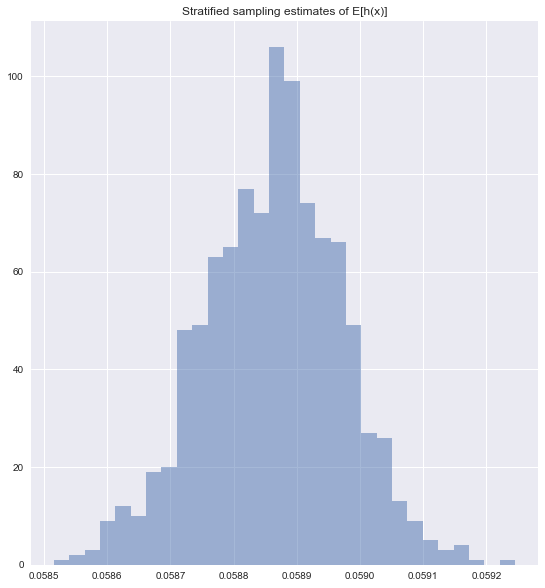

In [90]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,2)
plt.hist(Eh_stratified,30,alpha=0.5)
plt.title('Stratified sampling estimates of E[h(x)]')
plt.legend()
print("Variance of the estimates: ", np.var(Eh_stratified))

(array([   0.,   20.,   40.,   60.,   80.,  100.,  120.]),
 <a list of 7 Text yticklabel objects>)

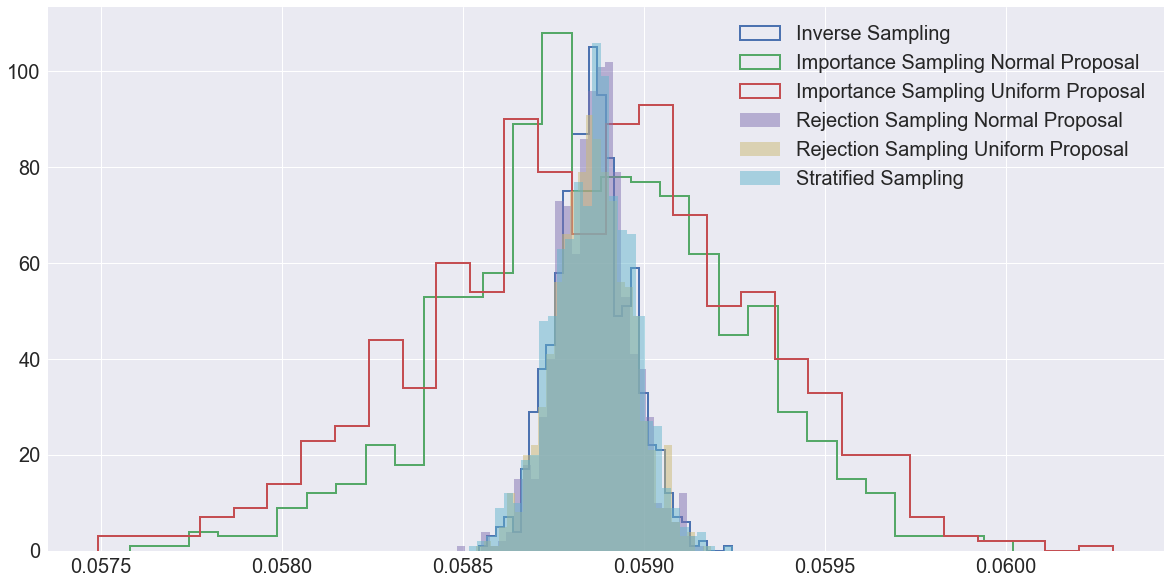

In [91]:
plt.figure(figsize=(20,10))
plt.hist(Eh_inverse,bins=30, histtype='step', linewidth=2, label='Inverse Sampling');
plt.hist(Eh_imp_normal,bins=30,histtype='step',linewidth=2, label='Importance Sampling Normal Proposal');
plt.hist(Eh_imp_uniform,bins=30, histtype='step',linewidth=2,label='Importance Sampling Uniform Proposal');
plt.hist(Eh_rej_normal, bins=30, alpha = 0.5, label='Rejection Sampling Normal Proposal');
plt.hist(Eh_rej_uniform,bins=30, alpha = 0.5,label='Rejection Sampling Uniform Proposal');
plt.hist(Eh_stratified,30,alpha=0.5, label='Stratified Sampling')
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

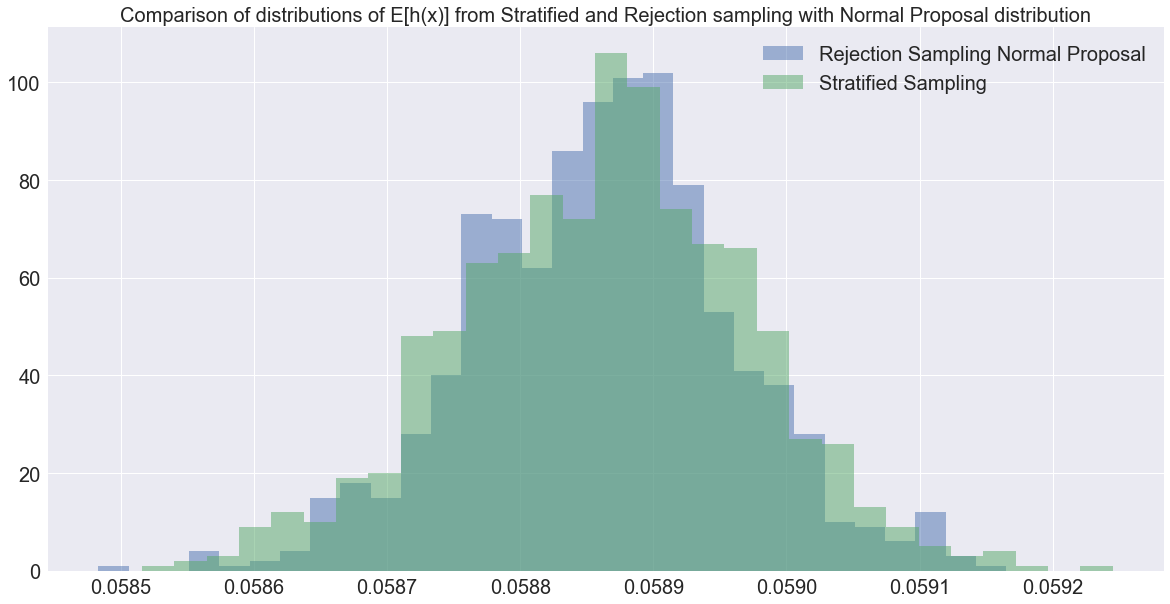

In [92]:
plt.figure(figsize=(20,10))
plt.hist(Eh_rej_normal, bins=30, alpha = 0.5, label='Rejection Sampling Normal Proposal');
plt.hist(Eh_stratified,30,alpha=0.5, label='Stratified Sampling')
plt.legend(fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title('Comparison of distributions of E[h(x)] from Stratified and Rejection sampling with Normal Proposal distribution', fontsize=20)

In [93]:
print("Inverse Sampling: ", np.var(Eh_inverse))
print("Importance Sampling Normal Proposal: ", np.var(Eh_imp_normal))
print("Importance Sampling Uniform Proposal: ", np.var(Eh_imp_uniform))
print("Rejection Sampling Normal Proposal: ", np.var(Eh_rej_normal))
print("Rejection Sampling Uniform Proposal: ", np.var(Eh_rej_uniform))
print("Stratified Sampling Normal proposal: ", np.var(Eh_stratified))

Inverse Sampling:  1.03864453742e-08
Importance Sampling Normal Proposal:  1.41350454453e-07
Importance Sampling Uniform Proposal:  1.96238314507e-07
Rejection Sampling Normal Proposal:  9.73230267846e-09
Rejection Sampling Uniform Proposal:  1.02586540644e-08
Stratified Sampling Normal proposal:  1.1846381081e-08


The estimates obtained using rejection sampling with normal proposal distribution and stratified sampling with normal proposal distribution have very similar variances and there is no significant reducation in variance through stratification. Again this is dependent on the selection of proposal distribution.  